<center><b>
<span style="font-size: 2em;">
VTKtools Documentation</span><br><span style="font-size: 1em;">
Last Update: 06/2018</span>  
</b></center>

In [1]:
using PyPlot
using QuadGK
using Roots

module_path,_ = splitdir(@__FILE__);   # Path to this module

# Load VTKtools
include(joinpath(module_path,"../src/VTKtools.jl"))
using VTKtools
vtk = VTKtools

# Load examples
include(joinpath(module_path,"../examples/examples.jl")) 
examples = VTKtools_examples

# Path to data files
data_path = examples.data_path

# Inline plots
pygui(false);

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [11]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
"""

# Geometric Manipulation

## Discretization

In [2]:
?vtk.discretize

`discretize(f, xlow, xhigh, n::Int64, r::Float64; central::Bool=false)`

Discretizes the continuous function `f` between the range `xlow` and `xhigh` into `n` intervals, with `r` the ratio between first and last interval if `central=false` or between first and central interval if `central=true`.

**Examples**

The following lines show the discretization of a semi-circumference perimeter   into 100 intervals of uniform length:

`julia     julia> f(x) = (x, sqrt(1-round(x,8)^2), 0)  # Semi-circunference of radius 1     julia> discretize(f, -1, 1, 100, 1.0)`


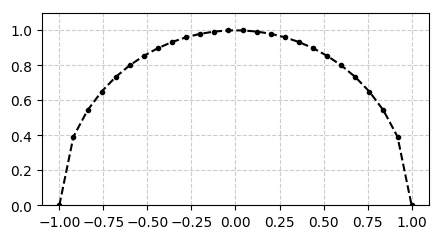

In [3]:
f(x) = (x, sqrt(1-round(x,8)^2), 0)

points = vtk.discretize(f, -1, 1, 25, 1.0)

function plot1(points)
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(5,2.5))
    plot(x,y, "--.k")
    xlim([-1, 1]*1.1)
    ylim([0, 1]*1.1)
    grid(true, color="0.8", linestyle="--")
end

plot1(points)

However, parameterizing the curve as `f(x) = (x, sqrt(1-x^2), 0)`, the discretization was done evenly spaced in `x`. If we want to evenly space the path of the curve, we'd be better off parameterizing it as `f(theta) = (cos(theta), sin(theta), 0)`:

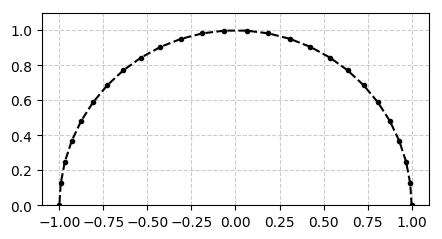

In [4]:
f(theta) = (cos(theta), sin(theta), 0)
points = vtk.discretize(f, 0, pi, 25, 1.0)
plot1(points)

That looks better. If now we want to increase the step size as we go along the curve (`r=1/8`):

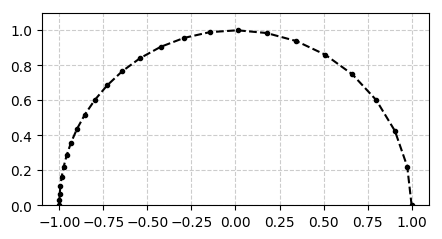

In [5]:
points = vtk.discretize(f, 0, pi, 25, 1/8)
plot1(points)

If we want to center that spacing we give `central=true`:

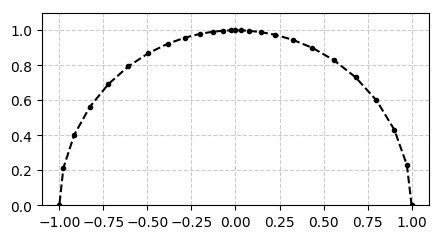

In [6]:
points = vtk.discretize(f, 0, pi, 25, 1/8; central=true)
plot1(points)

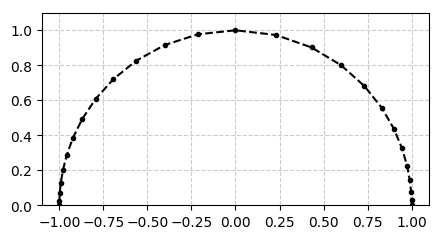

In [7]:
points = vtk.discretize(f, 0, pi, 25, 8.0; central=true)
plot1(points)

In order to define multiple sections of refinement, the function `multidiscretize` can be used:

In [8]:
?vtk.multidiscretize

`multidiscretize(f, xlow, xhigh, sections)`

Discretizes the continuous function `f` between the range `xlow` and `xhigh` into multiple sections of refinement as specified in `sections`.

** Arguments **

  * `f`         : Continuous function of the form `f(x)` to be discretized               between `xlow` and `xhigh`,
  * `xlow`      : Lower bound.
  * `xhigh`     : Upper bound.
  * `sections`  : Array `[sec1, sec2, ...]`specifying the               sections of discretization in the format               `sec = (c::Float64, n::Int64, r::Float64, central::Bool)`,               with `c` the normalized length of this section (the sum of all               c must equal one), `n` the number of intervals in this section               , `r` the increment ratio between first and last interval if               `central=false` or between first and central interval if               `central=true`.

**Examples**

The following lines show the discretization of a semi-circumference perimeter   into 90 intervals done in three sections of discretization:

`julia     julia> f(theta) = (cos(theta), sin(theta), 0)     julia> sec = (1/3, 30, 1/8, true)     julia> points = multidiscretize(f, 0, pi, [sec, sec, sec])`


Here we will discretize the semi-circle in three different sections of refinement:

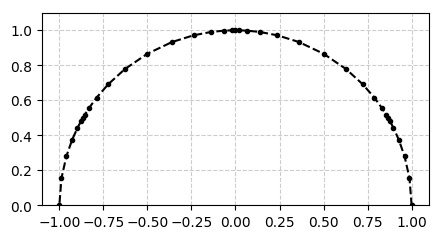

In [9]:
sec = (1/3, 12, 1/8, true)
points = vtk.multidiscretize(f, 0, pi, [sec, sec, sec])

plot1(points)

Let's verify that the are returned in the right order:

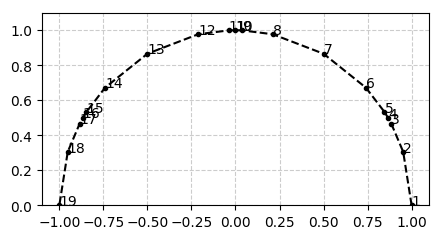

In [10]:
sec = (1/3, 6, 1/8, true)
points = vtk.multidiscretize(f, 0, pi, [sec, sec, sec])

plot1(points)

# Numbering
for (i,(x,y,z)) in enumerate(points)
    annotate("$i", xy=(x,y), xytext=(x,y))
end

## Meshing

In order to exemplify how to mesh on a surface, we will show the example of a helicoidal surface. First, outer and inner edges are defined analytically:

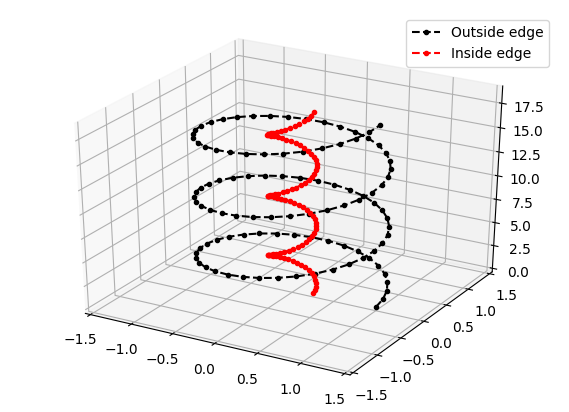

In [38]:
# Helicoid function
rho,k = 1,1
f(z) = [rho*cos(k*z), rho*sin(k*z), z]

# Discretize
points1 = vtk.discretize(f, 0, 3*2*pi, 100, 1.0)
rho = rho/4
points2 = vtk.discretize(f, 0, 3*2*pi, 100, 1.0)

function plot2(points; label="", style="--.k")
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(7,5))
    ax = gca(projection="3d")
    plot(x,y,z, style, label=label)
    xlim([-1, 1]*1.5)
    ylim([-1, 1]*1.5)
    if label!=""
        legend(loc="best")
    end
end

plot2(points1; label="Outside edge")
plot2(points2; label="Inside edge", style="--.r");

In [13]:
?vtk.lines2vtkcells

`lines2vtkcells(line1::Array{Array{Float64,1}},line2::Array{Array{Float64,1}};                     point_data1, point_data2)`

Given two lines with the same amount of points, it generate cells in VTK format by matching the points between lines. For instance:

`julia   julia> line1 = [p11,p12,p13]   julia> line2 = [p21,p22,p23]   julia> lines2vtkcells(line1, line2)   (points, vtk_cells, point_data)` where `points=[p11,p12,p13,p21,p22,p23]`, and `vtk_cells=[[0,1,4,3],[1,2,5,4]]`.

Give it point data corresponding to points in each line through `point_data1` and `point_data2`, and it return it through `point_data` formatted for `generateVTK`'s `point_data` input.

Prefer this method over `generateCells()` since it will store the data efficiently when generating the VTK.


The entire case can is found in `parametric_mesh()` under `examples.jl`, resulting in the following geometry:

<img src="img/helicoid00.png" alt="Pic here" style="width: 600px;"/>

Run the following cell to generate and visualize the mesh in Paraview:

In [16]:
examples.parametric_mesh(; prompt=false)

And `parametric_mesh2()` adds divisions in between outer and inner edges:

<img src="img/helicoid01.png" alt="Pic here" style="width: 600px;"/>

Run the following cell to generate and visualize the mesh in Paraview:

In [17]:
?vtk.lines2vtkmulticells

`lines2vtkmulticells(line1, line2,                           sections::Array{Tuple{Float64,Int64,Float64,Bool},1},                           point_data1=nothing, point_data2=nothing)`

Like `lines2vtkcells()` it generates cells between two lines, but allows to define multiple rows of cells in between. The rows are given by `sections`, which is the same variable `sections` defined in `VTKtools_geometry.jl`'s `multidiscretize()` function, which divides the space in between the lines. For more details see docstring of `lines2vtkcells()` and `multidiscretize()`.


In [18]:
examples.parametric_mesh2(; prompt=false)

## Parametrization

### 2D Case - Semicircle

Given a set of 2D points $X = \{(x,y)\}$ that define a discretized 2D contour, the contour will be parametrized using the path of the contour. First, the contour is splined defining the function $f$ such that $X$ becomes $X = \{(x, f(x))\}$. The path $\Delta s$ between $(x,\mathop{}f(x))$ and $(x+\Delta x, \mathop{}f(x+\Delta x))$  is 

\begin{align}
        \Delta s(x, \Delta x) & = \sqrt{ (\Delta x)^2 + (f(x+\Delta x) - f(x))^2 }
    \\
        & = \sqrt{ 1 + \Big(\frac{f(x+\Delta x) - f(x)}{\Delta x}\Big)^2 } (\Delta x)
.\end{align}

In the limit $\Delta x\rightarrow 0$, 

\begin{align}
        \text{d} s (x) & = 
            \sqrt{ 1 + \Big(\frac{\text{d} f}{\text{d} x}(x)\Big)^2 } \text{d} x
;\end{align}

hence, the path $s$ from $(x_\text{min}, f(x_\text{min}))$ to an arbitrary point $(x, f(x))$ is calculated as

\begin{align}
    s(x) = \int\limits_{x_\text{min}}^{x} 
            \sqrt{ 1 + \Big(\frac{\text{d} f}{\text{d} x}(x^\prime)\Big)^2 } 
                            \text{d} x^\prime
\end{align}

For instance, lets show the path of the semi-circle used above, where the analytical circunference is originally discretized in $x$ instead of $\theta$, making non-evenly spaced discretization. The code below shows the spline (function $f(x)$) through the points resulting from the discretization, and the path function $s(x)$ is defined:

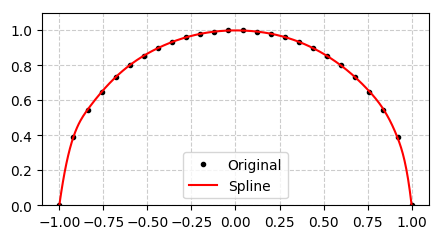

Path length between xmin=-1 and x=1: 3.136808464134872
Expected value: π = 3.1415926535897...


In [22]:
# Semi-circunference parameterized about x
f(x) = (x, sqrt(1-round(x,8)^2), 0)

# Discretize into points non-evenly spaced
points = vtk.discretize(f, -1, 1, 25, 1.0)

# Plot
function plot3(points; label="", style="--.k")
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(5,2.5))
    plot(x,y, style, label=label)
    xlim([-1, 1]*1.1)
    ylim([0, 1]*1.1)
    grid(true, color="0.8", linestyle="--")
    if label!=""; legend(loc="best"); end;
end

plot3(points; label="Original", style=".k")

# Fitting a spline through the points
x = [point[1] for point in points]
y = [point[2] for point in points]
bc="extrapolate"                 # Out of boundary case
s=0.0001                   # Spline smoothness
k = min(size(x)[1]-1, 3)   # Spline order
spl = vtk.Dierckx.Spline1D(x, y; k=k, bc=bc, s=s)

# Plots the spline
points2 = [(xi, spl(xi), 0) for xi in -1:0.005:1]
plot3(points2; label="Spline", style="-r")

# Defines the path function
dfdx(x) = vtk.Dierckx.derivative(spl, x)        # Derivative of f
fun(x) = sqrt.(1+(dfdx(x)).^2)                  # Integrand
fun_s(this_x) = quadgk(fun, x[1], this_x)[1]    # Integral between xmin and x

# Verification: path at x=1 should be 3.1415926535897...
println("Path length between xmin=-1 and x=1: $(fun_s(1.0))")
println("Expected value: $pi")

Now we will use the path function $s$ as a parametrization for re-discretizing the curve into evenly-spaced intervals. First, we normalize the path function as 

\begin{align}
    s^*(x) = \frac{s(x)}{s_\text{tot}}
,\end{align}

with $s_\text{tot} = s(x_\text{max})$. Next we define the inverse function $s^{-1}(s) = x$, or the normalized inverse function $s^{-1*}(s^*) = s^{-1}(s_\text{tot} s^*) = x$. Hence, $s^{-1*}$ receives any number between 0 and 1 representing the position along the path, and returns the value of $x$ that corresponds to that position. Implementing this numerically requires using a root finder as follows:

In [23]:
stot = fun_s(x[end])      # Total length of the path
norm_s(x) = fun_s(x)/stot # Normalized path function

function inv_norm_s(sstar; debug=false)
    # ERROR CASES
    if sstar<-0.001 || sstar>1.001 # Outside of domain
        error("Invalid normalized path length $(sstar) (sstar<0 || sstar>1)")
    end
    
    # Finds the x that matches the target (sstar)
    this_fun(x) = sstar - norm_s(x)
    bracket = [ x[1]*(1-0.01*sign(x[1])) , x[end]*(1+0.01*sign(x[end]))]
    if debug
        println("sstar=$sstar\tbracket=$bracket")
        println("flow=$(this_fun(bracket[1]))")
        println("fup=$(this_fun(bracket[2]))")
    end
    this_x = Roots.find_zero(this_fun, bracket, Roots.Bisection())
    
    return this_x
end

# Verification: x for s*=0.5 must equal 0
println("x for s*=0.5 (half way the path): $(inv_norm_s(0.5))")
println("Expected value: 0.0")

x for s*=0.5 (half way the path): -0.00048069199737853794
Expected value: 0.0


Now we can use this new parameterization to re-discretize the curve into evenly-spaced intervals. First we redefine the original function $f$ as $f^*: [0,1]\rightarrow \mathbb{R}^3 \mathop{/} f^*(s^*) = f(s^{-1*}(s^*))$, and then we discretize $s^*$ as we may in [0,1]:

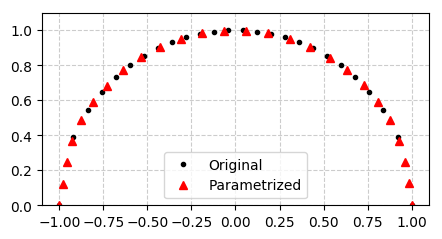

In [27]:
# Redefine the original function in terms of the new parametrization s*
function fstar(sstar)
    x = inv_norm_s(sstar)
    return (x, spl(x), 0)
end

# Discretize into points evenly spaced
points3 = vtk.discretize(fstar, 0, 1, 25, 1.0)
plot3(points; label="Original", style=".k")
plot3(points3; label="Parametrized", style="^r");

And we get an evenly-spaced discretization. Also, we can use this new parametrization to re-discretizase the original curve as we please:

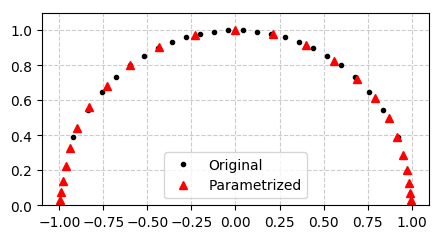

In [26]:
# Finer discretization at the ends
points4 = vtk.discretize(fstar, 0, 1, 25, 8.0; central=true)
plot3(points; label="Original", style=".k")
plot3(points4; label="Parametrized", style="^r");

### 3D Case - Helicoid

This paramaetrization method for obtaining $f^*$ is implemented in `parameterize()`, which receives a 3D contour line and returns the function $f^*$:

In [28]:
?vtk.parameterize

`parameterize(x, y, z; inj_var::Int64=1, s=0.0001, debug=false)`

Receives a contour (line) and returns a parametrization function f(s) of the contour. The parametrization is done on the path of the splined contour such that f(0.5) returns the point (x,y,z) where half of the entire contour has been walked, and f(1.0) returns the last point in the contour. To perform this parametrization, the contour must be injective in least one of the variables (x, y, or z) (i.e., all values of the variable are unique), and that variable must be given in increasing order.

**Arguments**

  * `x::Array{Float64,1}`    : x-coordinates of the contour.
  * `y::Array{Float64,1}`    : y-coordinates of the contour.
  * `z::Array{Float64,1}`    : z-coordinates of the contour.

**Optional Arguments**

  * `inj_var::Int64`         : Indicates the variable that is injective, with                               1=x, 2=y, and 3=z.
  * `s::Float64`             : Spline smoothness.

See Parametrization section in documentation for more details.


As an example, lets take a collection of points representing a helicoid as follows:

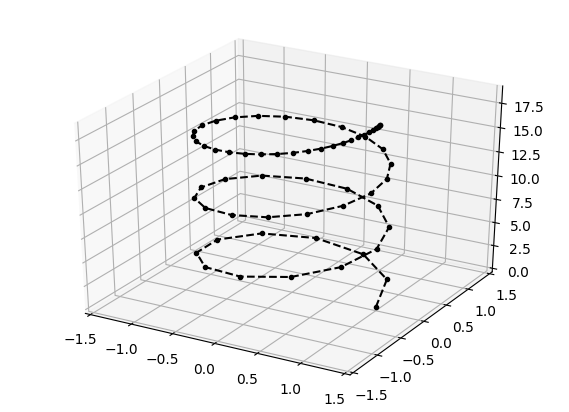

In [29]:
# Helicoid function
rho,k = 1,1
f(z) = [rho*cos(k*z), rho*sin(k*z), z]

# Discretize
points1 = vtk.discretize(f, 0, 3*2*pi, 60, 1/100.0)

function plot2(points; label="", style="--.k")
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(7,5))
    ax = gca(projection="3d")
    plot(x,y,z, style, label=label)
    xlim([-1, 1]*1.5)
    ylim([-1, 1]*1.5)
    if label!=""
        legend(loc="best")
    end
end

plot2(points1)

This curve has been discretize with a large concetration of points in the upper part, and very sparse in the bottom. We can use `parameterize` to obtain the curve again and be able to re-discretize is as we please:

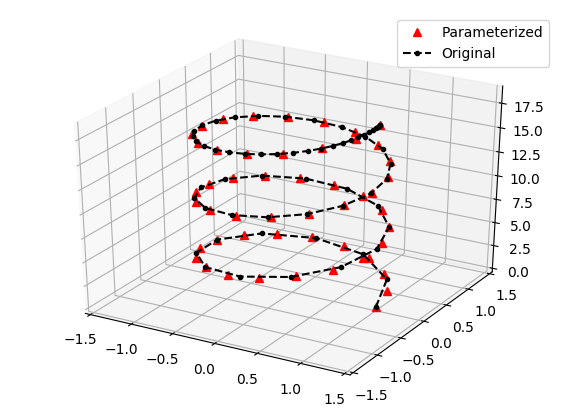

In [30]:
# Splits the points into x,y,z
x = [p[1] for p in points1]
y = [p[2] for p in points1]
z = [p[3] for p in points1]

# Parametrization function f*
this_fstar = vtk.parameterize(x,y,z; inj_var=3)
# Note: In this case the injective variable is z, hence inj_var=3

# Discretize f* evenly-spaced
points2 = vtk.discretize(this_fstar, 0, 1, 50, 1.0)

plot2(points2; style="^r", label="Parameterized")
plot2(points1; style="--.k", label="Original");

### Arbitrary geometry - Airfoil

Why is this useful?? Let's show an application of this on an airfoil.

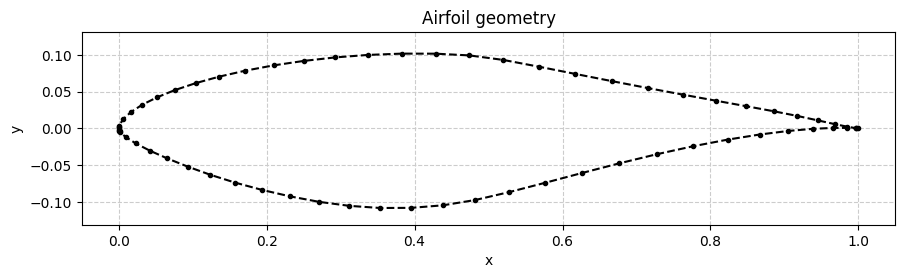

In [3]:
x,y = examples.readcontour(joinpath(data_path, "S809.txt"); header_len=2)
examples.plot_airfoil(x,y; style="--.k")

We can use those parametrization and discretization methods for redoing the sectioning of the airfoil in a more refined, evenly-spaced discretization:

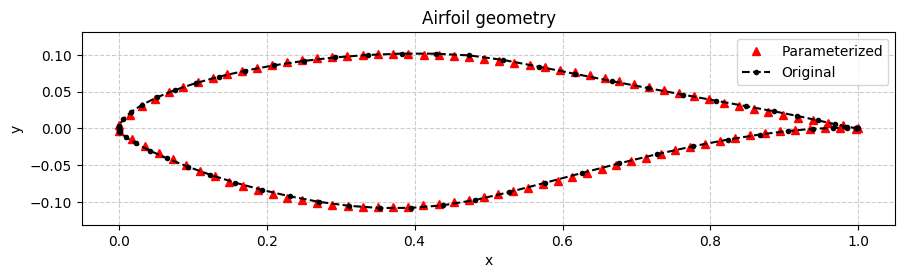

In [35]:
# Separate upper and lower surfaces to make the contour injective in x
upper, lower = examples.splitcontour(x,y)

# Parameterize both surfaces independently
fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1)
fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1)

# New discretization for both surfaces
upper_points = vtk.discretize(fun_upper, 0, 1, 50, 1.0)
lower_points = vtk.discretize(fun_lower, 0, 1, 50, 1.0)

# Put both surfaces back together from TE over the top and from LE over the bottom.
reverse!(upper_points)                           # Trailing edge over the top
new_x = [point[1] for point in upper_points]
new_y = [point[2] for point in upper_points]     # Leading edge over the bottom
new_x = vcat(new_x, [point[1] for point in lower_points])
new_y = vcat(new_y, [point[2] for point in lower_points])

examples.plot_airfoil(new_x, new_y; style="^r", label="Parameterized")
examples.plot_airfoil(x,y; style="--.k", label="Original")
legend(loc="best");

Or maybe we want to refine leading and trailing edges, along the apex:

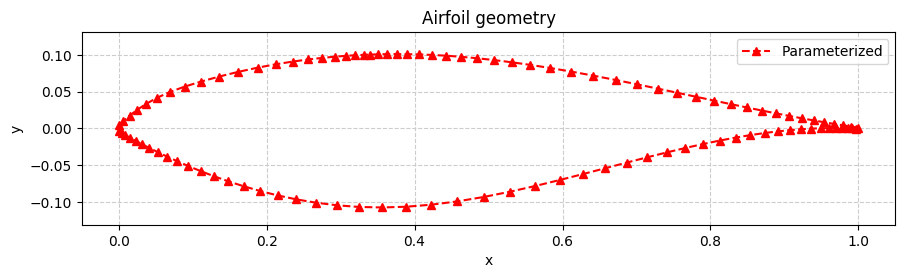

In [37]:
# Upper surface sections
sec1 = (0.35, 20, 3.0, true) # 35% of the line has 20 sections in ratio 3.0 around center
sec2 = (0.65, 33, 3.0, true) # 65% of the line has 33 sections in ratio 3.0 around center

# New discretization for both surfaces
upper_points = vtk.multidiscretize(fun_upper, 0, 1, [sec1,sec2])
lower_points = vtk.discretize(fun_lower, 0, 1, 50, 8.0; central=true)

# Put both surfaces back together from TE over the top and from LE over the bottom.
reverse!(upper_points)                           # Trailing edge over the top
new_x = [point[1] for point in upper_points]
new_y = [point[2] for point in upper_points]     # Leading edge over the bottom
new_x = vcat(new_x, [point[1] for point in lower_points])
new_y = vcat(new_y, [point[2] for point in lower_points])

examples.plot_airfoil(new_x, new_y; style="--^r", label="Parameterized");

## Example: Wing

Now we will show how we can use parametrization + discretization + meshing to create a geometry. This example is on an airplane wing, but the same procedure can be follow for defining any surface of lofted cross sections.

First, we take two airfoils as downloaded from airfoilstools.com, use `parametrize()` to parameterize their contours and `discretize()` to discretize with a finer sections towards both trailing and leading edge, and apex:

In [4]:

# PARAMETERS
n_up = 40             # Number of sections in upper surface of wing
n_lower = 20          # Number of sections in lower surface of wing
z1 = 0.0              # Position of first airfoil
z2 = 10.0             # Position of second airfoil
c1 = 2.5              # Chord of first airfoil
c2 = 1.0              # Chord of second airfoil
file_name = "temp_wing00"    # Name for vtk outpout file

# Reads the original airfoil geometry from airfoiltools.com
org_x1, org_y1 = examples.readcontour(joinpath(data_path, "naca6412.dat"); header_len=1)
org_x2, org_y2 = examples.readcontour(joinpath(data_path, "naca0006.dat"); header_len=1)

# Separate upper and lower sides to make the contour injective in x
upper1, lower1 = examples.splitcontour(org_x1, org_y1)
upper2, lower2 = examples.splitcontour(org_x2, org_y2)

# Parameterize both sides independently
fun_upper1 = vtk.parameterize(upper1[1], upper1[2], zeros(upper1[1]); inj_var=1)
fun_lower1 = vtk.parameterize(lower1[1], lower1[2], zeros(lower1[1]); inj_var=1)
fun_upper2 = vtk.parameterize(upper2[1], upper2[2], zeros(upper2[1]); inj_var=1)
fun_lower2 = vtk.parameterize(lower2[1], lower2[2], zeros(lower2[1]); inj_var=1)

# Upper surface sections
aux1 = Int(floor(20/53*n_up))
sec1 = (0.35, aux1, 3.0, true) # 35% of the line has 20 sections in ratio 3.0 around center
sec2 = (0.65, n_up-aux1, 3.0, true) # 65% of the line has 33 sections in ratio 3.0 around center

# New discretization for both surfaces
upper_points1 = vtk.multidiscretize(fun_upper1, 0, 1, [sec1,sec2])
lower_points1 = vtk.discretize(fun_lower1, 0, 1, n_lower, 8.0; central=true)
upper_points2 = vtk.multidiscretize(fun_upper2, 0, 1, [sec1,sec2])
lower_points2 = vtk.discretize(fun_lower2, 0, 1, n_lower, 8.0; central=true)

# Put both surfaces back together from TE over the top and from LE over the bottom.
reverse!(upper_points1)                           # Trailing edge over the top
new_x1 = [point[1] for point in upper_points1]
new_y1 = [point[2] for point in upper_points1]     # Leading edge over the bottom
new_x1 = vcat(new_x1, [point[1] for point in lower_points1])
new_y1 = vcat(new_y1, [point[2] for point in lower_points1])
reverse!(upper_points2)                           # Trailing edge over the top
new_x2 = [point[1] for point in upper_points2]
new_y2 = [point[2] for point in upper_points2]     # Leading edge over the bottom
new_x2 = vcat(new_x2, [point[1] for point in lower_points2])
new_y2 = vcat(new_y2, [point[2] for point in lower_points2])
println("")

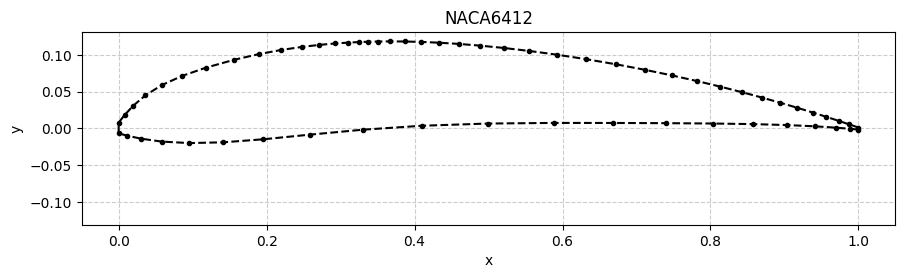

In [5]:
examples.plot_airfoil(new_x1, new_y1; style="--.k", title_str="NACA6412")

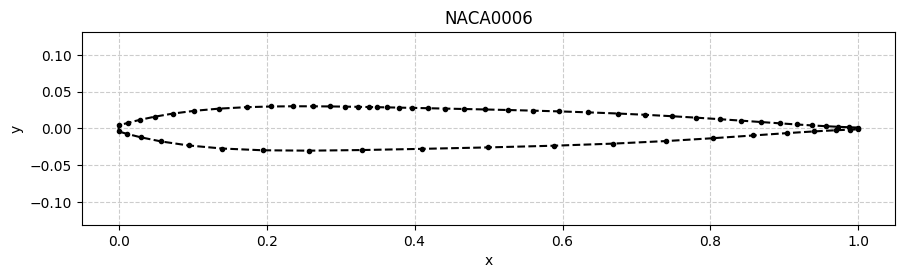

In [6]:
examples.plot_airfoil(new_x2, new_y2; style="--.k", title_str="NACA0006")

Now we can use `lines2vtkmulticells()` to generate a lofted 3D surface between both airfoils and output it in VTK Legacy format using `generateVTK()`:

In [7]:
npoints = size(new_x1)[1]         # Number of points on each airfoil contour
# Dimensions the airfoil acording to their chord length and positions them in z
airfoil1 = [[c1*new_x1[i], c1*new_y1[i], z1] for i in 1:npoints]
airfoil2 = [[c2*new_x2[i], c2*new_y2[i], z2] for i in 1:npoints]

# Discretization of the lofting between the airfoils
nloft = 50                      # Number of sections
rloft = 10.0                   # Expansion ratio
central = true                  # Expands about center between edges
sections = [(1.0, nloft, rloft, central)]   # Discretization sections

# Dummy point data for good looking visuals
pd1 = [i for i in 1:size(airfoil1)[1]]
pd2 = size(airfoil1)[1]+[i for i in 1:size(airfoil2)[1]]

# Generates cells in VTK Legacy format
out = vtk.lines2vtkmulticells(airfoil1, airfoil2, sections;
                                        point_data1=pd1, point_data2=pd2)
points, vtk_cells, point_data = out


# Formats the point data for generateVTK
data = []
push!(data, Dict(
              "field_name" => "Point_index",
              "field_type" => "scalar",
              "field_data" => point_data
              )
   )


# Generates the vtk file
vtk.generateVTK(file_name, points; cells=vtk_cells, point_data=data)

Visualize in Paraview:

In [8]:
# Calls paraview
run(`paraview --data="$(file_name).vtk;"`)

# Deletes files
if false
 print("Delete vtk files? ([y]/n) ")
 y = readline()
else
 y = "y"
end
if y=="y"; run(`rm -f $(file_name).vtk`); end;


<img src="img/wing00.png" alt="Pic here" style="width: 600px;"/>
<img src="img/wing01.png" alt="Pic here" style="width: 600px;"/>
<img src="img/wing02.png" alt="Pic here" style="width: 600px;"/>

## Example: Blade

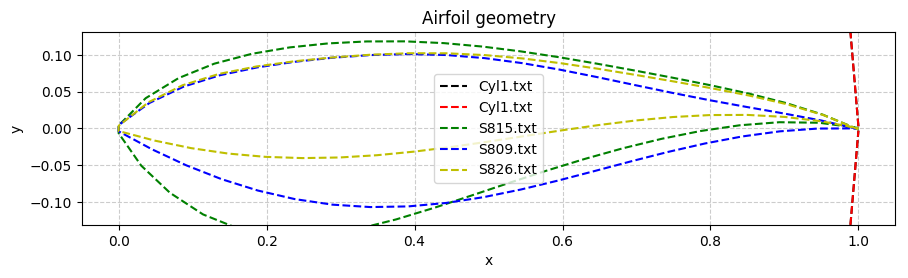

In [9]:
airfoil_files = ["Cyl1.txt", "Cyl1.txt", "S815.txt", "S809.txt", "S826.txt"]
file_name = "temp_blade00"    # Name for vtk outpout file
prompt = false

# PARAMETERS
n_upper = 20             # Number of sections in upper surface of blade
n_lower = 20          # Number of sections in lower surface of blade
r = [1.0, 1.0, 8.0, 8.0, 8.0]           # Expansion ratio in both surfaces of each airfoil
sections = [[(1.0, 10, 1.0, false)],      # Discretization between each airfoil
          [(1.0, 5, 1.0, false)],
          [(1.0, 15, 1.0, false)],
          [(1.0, 10, 1.0, false)],
  ]

Rtip = 25.0           # Radius at blade tip
Rhub = 1.0            # Radius of the hub
pos = [0, 0.15, 0.2, 0.5, 1.0]           # Position along blade of each airfoil
chords = [1.0, 0.6, 1.75, 3.0, 0.85]    # Chord length of each airfoil

# Leading edge position of each airfoil
Os = [[-chords[1]/2, 0, Rhub+pos[1]*(Rtip-Rhub)],
      [-chords[2]*7/8, 0, Rhub+pos[2]*(Rtip-Rhub)],
      [-chords[3]*4/6, 0, Rhub+pos[3]*(Rtip-Rhub)],
      [-chords[4]/4, 0, Rhub+pos[4]*(Rtip-Rhub)],
      [-chords[5]/8, 0, Rhub+pos[5]*(Rtip-Rhub)]
  ]
# Orientation of chord of each airfoil (yaw, pitch, roll)
orien = [ [0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0],
          [10.0, 0.0, 0.0],
          [7.5, 0.0, 0.0],
          [0.0, 30.0, 0.0]
]

crosssections = []        # It will store here the cross sections for lofting
point_datas = []          # Dummy point data for good looking visuals

# Processes each airfoil geometry
styles = ["--k", "--r", "--g", "--b", "--y", "--c"]
org_points = []
for (i,airfoil_file) in enumerate(airfoil_files)

  # Read airfoil file
  x,y = examples.readcontour(joinpath(data_path, airfoil_file); header_len=2)
  push!(org_points, [x,y])

  # Separate upper and lower sides to make the contour injective in x
  upper, lower = examples.splitcontour(x, y)

  # Parameterize both sides independently
  fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1)
  fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1)

  # New discretization for both surfaces
  upper_points = vtk.discretize(fun_upper, 0, 1, n_upper, r[1]; central=true)
  lower_points = vtk.discretize(fun_lower, 0, 1, n_lower, r[1]; central=true)

  # Put both surfaces back together from TE over the top and from LE over the bottom.
  reverse!(upper_points)                           # Trailing edge over the top
  new_x = [point[1] for point in upper_points]
  new_y = [point[2] for point in upper_points]      # Leading edge over the bottom
  new_x = vcat(new_x, [point[1] for point in lower_points])
  new_y = vcat(new_y, [point[2] for point in lower_points])

  examples.plot_airfoil(new_x, new_y; style=styles[i], label=airfoil_file)
#     println("Close figure and press ENTER")
#     readline()

  # Scales the airfoil acording to its chord length
  new_x = chords[i]*new_x
  new_y = chords[i]*new_y

  # Reformats into points
  npoints = size(new_x)[1]
  airfoil = Array{Float64, 1}[[new_x[j], new_y[j], 0] for j in 1:npoints]

  # Positions the airfoil along the blade in the right orientation
  Oaxis = vtk.rotation_matrix(orien[i][1], orien[i][2], orien[i][3])
  invOaxis = inv(Oaxis)
  airfoil = vtk.countertransform(airfoil, invOaxis, Os[i])

  push!(crosssections, airfoil)
  push!(point_datas, [j for j in npoints*(i-1)+1:npoints*i])
end

# Generates cells in VTK Legacy format
out = vtk.multilines2vtkmulticells(crosssections, sections;
                                    point_datas=point_datas)
points, vtk_cells, point_data = out


# Formats the point data for generateVTK
data = []
push!(data, Dict(
          "field_name" => "Point_index",
          "field_type" => "scalar",
          "field_data" => point_data
          )
)


# Generates the vtk file
vtk.generateVTK(file_name, points; cells=vtk_cells, point_data=data)

# Calls paraview
run(`paraview --data="$(file_name).vtk;"`)


# Deletes files
if prompt
print("Delete vtk files? ([y]/n) ")
y = readline()
else
y = "y"
end
if y=="y"; run(`rm -f $(file_name).vtk`); end;


<img src="img/blade00.png" alt="Pic here" style="width: 600px;"/>
<img src="img/blade01.png" alt="Pic here" style="width: 600px;"/>
<img src="img/blade02.png" alt="Pic here" style="width: 600px;"/>

# Grids

## Grid Definition

In [41]:
? vtk.Grid

`Grid(P_min, P_max, NDIVS)`

Generates an n-dimensional grid.

**Arguments**

  * `P_min::Array{Float64,1}`   : Minimum point of the domain.
  * `P_max::Array{Float64,1}`   : Maximum point of the domain.
  * `NDIVS::Array{Int64,1}`     : Number of divisions in each coordinate.

**Properties**

  * `dims::Int64`               : Number of dimensions.
  * `nnodes::Int64`             : Number of nodes in the grid.
  * `nodes::Array{Float64,2}`   : Matrix size (`nnodes`, 3) of node position.
  * `field` : Contains calculated fields formated as field[field_name] = Dict(                         "field_name" => field_name::String,                         "field_type" => "scalar" or "vector",                         "field_data" => data                         )         where `data` is an array data[i] = [val1, val2, ...] containing         this field values (scalar or vector) at each node in the grid.

NOTE: All indexing is done linearly, meaning that `nodes` is indexed from 1 to       `nnodes`, and all data fields follow the same indexing.

NOTE2: `NDIVS` can either be an array of integers with NDIVS[i] indicating the       number of divisions in the i-th coordinate, or it can be an array of       sections (see `multidiscretize()` doc) with NDIVS[i] = [sec1, sec2, ...]       indicating the discretization into sections in the i-th coordinate.


In [3]:
? vtk.get_node

`get_node(grid, i)`

Returns the position of the i-th node (1-indexed) in the grid

`get_node(grid, coor)`

Returns the position of the node of subscript coordinates `coor` (1-indexed)


In [4]:
? vtk.get_cell

`get_cell(grid, i)`

Returns the nodes indices of i-th cell in the grid (1-indexed)

`get_cell(grid, coor)`

Returns the node indices of the cell with subscript coordinates `coor` (1-indexed). The format corresponds to VTK_HEXAHEDRON (=12) in 3D, VTK_QUAD (=9) in 2D, or VTK_LINE (=3) in 1D–-except that points are 1-indexed instead of 0-indexed.


|     |     |     |
|:---:|:---:|:---:|
|<img src="img/vtk00.png" alt="Pic here" style="width: 200px;"/>|<img src="img/vtk01.png" alt="Pic here" style="width: 150px;"/>|<img src="img/vtk02.png" alt="Pic here" style="width: 200px;"/>|

### Example: Simple Cube

Here is a cube of unit length with the bottom left back corner at the origin. The grid defines 3 sections in x, 2 sections in y, and 1 section in z by giving it `NDIVS = [3,2,1]`.
<img src="img/cube00.png" alt="Pic here" style="width: 500px;"/>

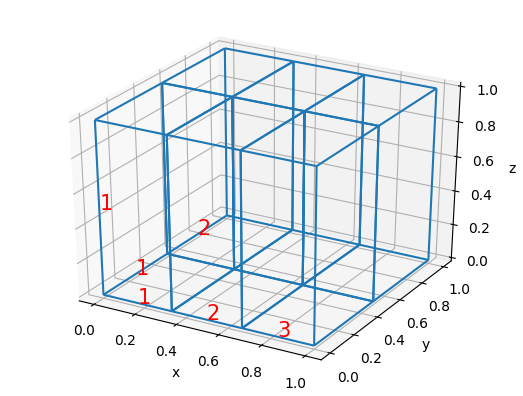

In [6]:
file_name = "temp_cubegrid00"
paraview = false

# Defines a cube of unit length with the bottom left corner at origin
P_min = zeros(3)     # Bottom left back corner
P_max = ones(3)      # Top right front corner
NDIVS = [3,2,1]      # 3 sections in x, 2 sections in y, 1 sections in z

# Generates the grid object
grid = vtk.Grid(P_min, P_max, NDIVS)

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end

### Example: Refined Cube

Now we have the same cube, but this time we will define sections of refiment in each coordinate: two points in x, boundaries in y, and z will stay as only one section. This is done by giving it 

```julia
NDIVS = [  # x sections
           [(1/3, 10, 1/5, false),
            (1/3, 20, 5.0, true), 
            (1/3, 10, 5.0, false)],
           # y sections
           [(1.0, 30, 5.0, true)],   
           # z sections
           [(1.0, 1, 1.0, false)]    
        ]
```
`NDIVS` defines sections of refinement in each coordinate as `NDIVS[i] = [sec1, sec2, ...]` the sections in the i-th coordinate, where `sec = (c::Float64, n::Int64, r::Float64, central::Bool)`. See documentation of `multidiscretize` for more details.
 
<img src="img/cube01.png" alt="Pic here" style="width: 500px;"/>

In [64]:
file_name = "temp_cubegrid01"
paraview = true

# Defines a cube of unit length with the bottom left corner at origin
P_min = zeros(3)     # Bottom left back corner
P_max = ones(3)      # Top right front corner

# Defines sections of refinement in each coordinate as NDIVS[i] = [sec1, sec2, ...]
# the sections in the i-th coordinate, where 
# sec = (c::Float64, n::Int64, r::Float64, central::Bool). See documentation of
# `multidiscretize` for more details.
NDIVS = [ [(1/3, 10, 1/5, false), # x sections
            (1/3, 20, 5.0, true), 
            (1/3, 10, 5.0, false)], 
          [(1.0, 30, 5.0, true)],   # y sections
          [(1.0, 1, 1.0, false)]    # z sections
        ]

# Generates the grid object
grid = vtk.Grid(P_min, P_max, NDIVS)

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end

## Space Transformation

In [9]:
? vtk.transform!

`transform!(grid::Grid, f)`

Applies the space transformation given by function `f` to the grid.


In [10]:
? vtk.lintransform!

`lintransform!(grid::Grid, M::Array{Float64,2}, T::Array{Float64,1})`

Rotates and translates the grid by the rotation matrix `M` and translation vector `T` (linear transformation).


Nonlinear [orthogonal space transformations](https://en.wikipedia.org/wiki/Orthogonal_coordinates) are implemented as `cylindrical3D(X)`, `cylindrical2D(X)`, `spherical3D(X)`, `parabolic3D(X)`, `paraboloidal3D(X)`, `elliptic3D(X; a=1)`, `prolate3D(X; a=1)`, `oblate3D(X; a=1)`, `bipolar3D(X; a=1)`, `toroidal3D(X; a=1)`, and `conical3D(X; b=2, c=1)`. 

For linear transformations, `rotation_matrix(yaw::Real, pitch::Real, roll::Real)` returns the rotation matrix of such angles, and `axis_rotation(r::Array{Float64, 1}, angle_deg::Float64)` returns the transformation matrix of rotation around an arbitrary axis of unit vector `r`.

The user can also define an arbitrary space transformation. The airfoil example in the Looped Grid section shows the example of transforming a quasi-one-dimensional line into an two-dimensional airfoil contour.

### Example: Circular Grid

Here we generate a two-dimensional circular grid by first defining the boundaries of the circular section $r_\text{min}, r_\text{max}, \theta_\text{min}, \theta_\text{max}$ as a cartesian grid of $P_\text{min}=(r_\text{min}, \theta_\text{min})$ and $P_\text{max}=(r_\text{max}, \theta_\text{max})$ and then applying a cylindrical transformation on the grid. The cylindrical transformations take the current coordinates of $x,y$ of the grid as $r,\theta$ for the new grid. In this case, $r_\text{min}=R/4$, $r_\text{max}=R$, $\theta_\text{min}=0^\circ$, $\theta_\text{max}=270^\circ$.

<img src="img/circ01.png" alt="Pic here" style="width: 600px;"/>

In [5]:
file_name = "temp_circgrid00"
paraview = true

R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 270*pi/180]   # Upper boundaries r, theta

NDIVS = [15, 60]          # 15 radius divisions, 60 angle divisions

# Generates the grid as cartesian
grid = vtk.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
vtk.transform!(grid, vtk.cylindrical2D)

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end

Notice that `NDIVS` can still be used to defined sections of refinement:

<img src="img/circ02.png" alt="Pic here" style="width: 600px;"/>

In [68]:
file_name = "temp_circgrid01"
paraview = true

NDIVS = [   # r sections
            [(1.0, 15, 5.0, true)],
            # theta sections
            [(1/3, 15, 1/3, false),
             (1/3, 15, 3.0, true),
             (1/3, 15, 3.0, false)]
        ]

# Generates the grid as cartesian
grid = vtk.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
vtk.transform!(grid, vtk.cylindrical2D)

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end

### Example: Parabolic Grid

<img src="img/parab00.png" alt="Pic here" style="width: 800px;"/>

In [2]:
file_name = "temp_parabgrid00"
paraview = true

P_min = [0.0, 0.0, 0.0]   # Lower boundaries
P_max = [1.0, 1.0, 1.0]   # Upper boundaries r, theta

NDIVS = [30, 30, 30] 

# Generates the grid as cartesian
grid = vtk.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
vtk.transform!(grid, vtk.parabolic3D)

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end

## Looped Grid

For some application it is convenient to be able to define a grid that loops on itself making the last cell in such dimension close back with the first cell. The Grid object accept an optional argument indicating the dimension that loops on itself as follows:

`Grid(P_min, P_max, NDIVS, loop_dim)`

where `loop_dim` is an integer indicating the dimension to loop.


Here below is an example of a cylindrical grid $(r, \theta)$ where by the nodes at $\theta=0^\circ$ and $\theta=360^\circ$ overlap by default (nodes 1, 2, and 3 overlap with 16, 17, and 18).

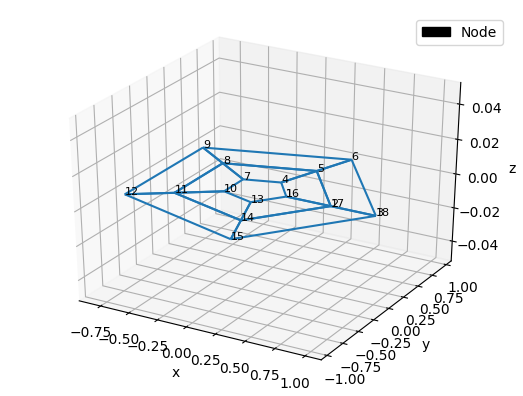

In [3]:
R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 360*pi/180]   # Upper boundaries r, theta

NDIVS = [2, 5]          # 15 radius divisions, 60 angle divisions

# Generates the grid as cartesian
grid = vtk.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
vtk.transform!(grid, vtk.cylindrical2D)

vtk.plot(grid; labelnodes=true, labelcells=!true, labelndivs=!true, fontsize=8);

By giving it the argument `loop_dim=2`, we get the $\theta$-coordinate loop on itself, getting rid of this node overlap by merging them:

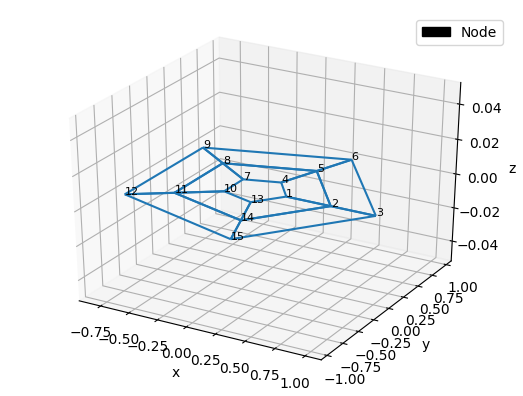

In [5]:
R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 360*pi/180]   # Upper boundaries r, theta

NDIVS = [2, 5]            # 2 radius divisions, 5 angle divisions
loop_dim = 2              # Loop the theta dimension

# Generates the grid as cartesian
grid = vtk.Grid(P_min, P_max, NDIVS, loop_dim)

# Converts to cylindrical
vtk.transform!(grid, vtk.cylindrical2D)

vtk.plot(grid; labelnodes=true, labelcells=!true, labelndivs=!true, fontsize=8);

### Airfoil Contour Example

Here we take the same airfoil we used for the parametric discretization example before, and we will use it for generating a grid that parameterizes the contour in a closed loop.

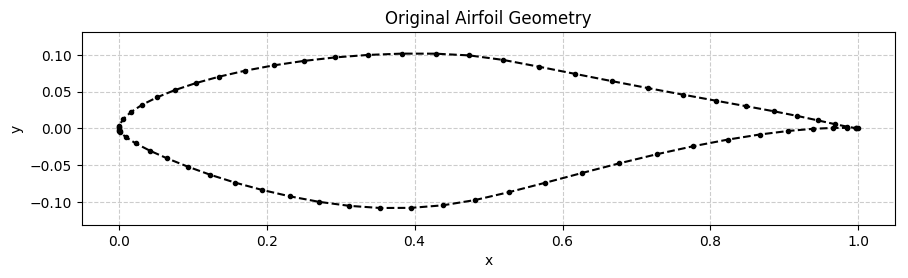

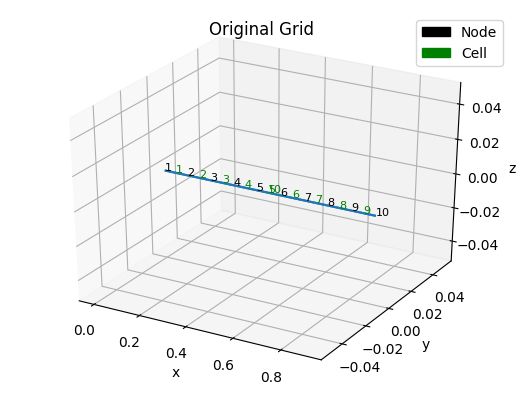

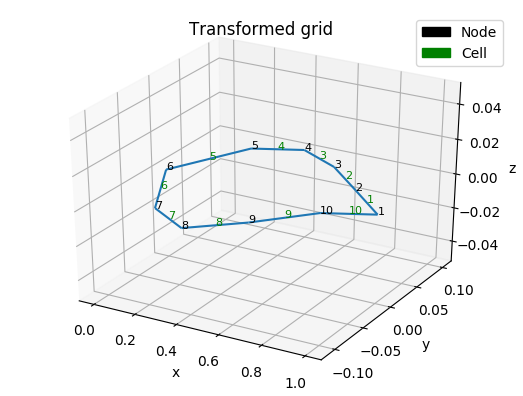

In [10]:
file_name = "temp_airfoilgrid00"
paraview = !true


# ----------------- READS AND PARAMETERIZES AIRFOIL ---------------------------
# Read airfoil contour
x,y = examples.readcontour(joinpath(data_path, "S809.txt"); header_len=2)
examples.plot_airfoil(x,y; style="--.k", title_str="Original Airfoil Geometry")

# Separate upper and lower surfaces to make the contour injective in x
upper, lower = examples.splitcontour(x,y)

# Parameterize both surfaces independently
fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1, s=1e-6)
fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1, s=1e-6)



# ----------------- CREATES GRID OF AIRFOIL CONTOUR ---------------------------
# Creates the grid as a quasi-one-dimensional line
#   `X[1]` is the arc-length around the airfoil contour (between 0 and 1),
#   `X[2]` is a dummy value.

P_min = [0, 0]             # Lower boundaries arclength, dummy
P_max = [1, 0]             # Upper boundaries arclength, dummy
NDIVS = [10, 0]            # 100 arclength divisions, 0 dummys
loop_dim = 1               # Loop the arclength dimension

grid = vtk.Grid(P_min, P_max, NDIVS, loop_dim)

vtk.plot(grid; labelnodes=true, labelcells=true, labelndivs=!true, 
                fontsize=8, fig_name="org", title_str="Original Grid")


# Creates a space transformation function
function my_space_transform(X)
    if X[1]<0.5
        return fun_upper(1-2*X[1])[1:2]
    else
        return fun_lower(2*(X[1]-0.5))[1:2]
    end
end

# Transforms the quasi-one-dimensional line into the two-dimensional
# airfoil contour
vtk.transform!(grid, my_space_transform)

vtk.plot(grid; labelnodes=true, labelcells=true, labelndivs=!true, 
                fontsize=8, title_str="Transformed grid");

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end

## Surface Grid (Quasi-dimensions)

A three-dimensional surface grid can be generated by defining three-dimensional grid where one of its dimensions has zero divisions, and then transforming the space into the surface geometry. A dimension with zero divisions is recognize as a "quasi-dimension", which is a place holder for space transformations without actually extending the dimensions of the grid. For instance, a three-dimensional grid with one quasi-dimension doesn't define its cells as VTK_HEXAHEDRONs as a regular three-dimensional grid would, but **its cells are defined as VTK_QUADs**. Also, quasi-dimensions are not considered as a coordinate direction, meaning that a node/cell in a three-dimensional grid with one quasi-dimension is not indexed by three coordinates $(i,j,k)$, but with **only two coordinates $(i,j)$**.

The following lines exemplify the process of defining the quasi-dimensional grid, and applying the space transformation:

```julia
# Creates quasi-three-dimensional grid
P_min = [0, -1, 0]            # Lower boundaries arclength, span, dummy
P_max = [1, 1, 0 ]            # Upper boundaries arclength, span, dummy
NDIVS = [20, 10, 0]           # 20 arclength cells, 10 span cells, 0 dummy
grid = vtk.Grid(P_min, P_max, NDIVS)


# Creates a space transformation function
function my_space_transform(X)
    new_X = # Write a new definition of each node here
    return new_X
end

# Applies the space transformation
vtk.transform!(grid, my_space_transform)
```

The following section examplifies the creation of wing surface grid.

### Paneled Wing Example

<img src="img/wing04.png" alt="Pic here" style="width: 800px;"/>
<img src="vid/wing04.gif" alt="Vid here" style="width: 800px;"/>

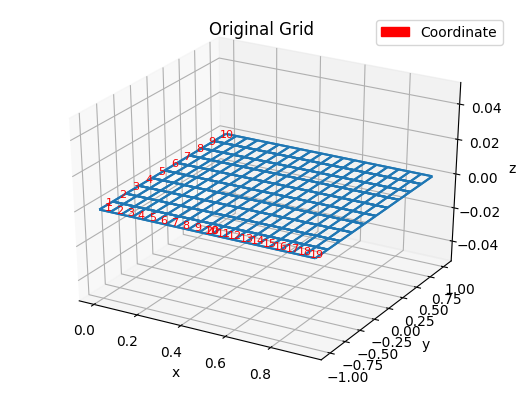

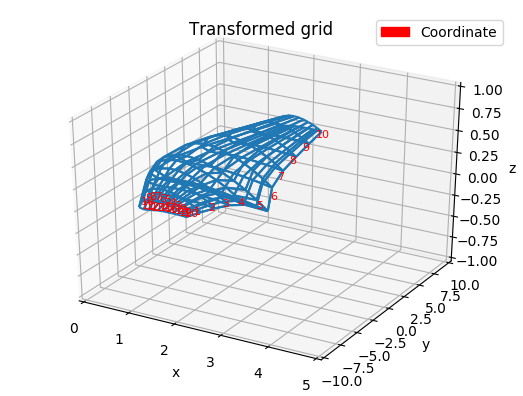

In [3]:
file_name = "temp_paneledwing00"
paraview = true

# ----------------- READS AND PARAMETERIZES AIRFOILS --------------------------
semispan = 10            # (m) semi-span length

chords = [(0, 2.5),      # (semi-span position, chord length (m))
          (0.25, 2.0),
          (1, 1.0)]

x_pos = [(0, 0),         # (semi-span position, leading edge x-position (m))
         (0.25, semispan/40 ),
         (1, semispan/8 )]

z_pos = [(0, 0),         # (semi-span position, leading edge z-position (m))
         (0.25, semispan/100 ),
         (1, semispan/50 )]

twist = [(0, 5),         # (semi-span position, twist (deg))
         (1, 0)]

airfoils = [(0, "naca6412.dat"), # (semi-span position, airfoil geometry)
            (1,"naca6412.dat")]

airfoil_funs = []

for (pos, airfoil_file) in airfoils
    # Reads the original airfoil geometry from airfoiltools.com
    org_x, org_y = examples.readcontour(joinpath(data_path, airfoil_file); header_len=1)

    # Separate upper and lower sides to make the contour injective in x
    upper, lower = examples.splitcontour(org_x, org_y)

    # Parameterize both sides independently
    fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1)
    fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1)
    
    push!(airfoil_funs, [pos, (fun_upper, fun_lower)])
end


# ----------------- CREATES PANEL GRID ----------------------------------------
P_min = [0, -1, 0]            # Lower boundaries arclength, span, dummy
P_max = [1, 1, 0 ]            # Upper boundaries arclength, span, dummy
NDIVS = [20, 10, 0]           # 50 arclength cells, 10 span cells, 0 dummy
loop_dim = 1                  # Loop the arclength dimension

grid = vtk.Grid(P_min, P_max, NDIVS, loop_dim)

vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, fig_name="org", title_str="Original Grid")


# Auxiliary function for weighting values across span
function calc_vals(span, array)
    
    # Finds bounding airfoil position
    val_in, val_out = nothing, array[1]
    for val in array[2:end]
        val_in = val_out
        val_out = val
        if val[1]>=abs(span); break; end
    end 
    pos_in = val_in[1]
    val_in = val_in[2]
    pos_out = val_out[1]
    val_out = val_out[2]
    
    weight = (abs(span)-pos_in)/(pos_out-pos_in)
            
    return weight, val_in, val_out
end

# Creates a space transformation function
function my_space_transform(X)
    span = X[2]
    
    # Calculates chord
    weight, chord_in, chord_out = calc_vals(span, chords)
    chord = weight*chord_out+(1-weight)*chord_in
    
    # Calculates airfoil geometry
    weight, rfl_in, rfl_out = calc_vals(span, airfoil_funs)
    fun_upper_in, fun_lower_in = rfl_in
    fun_upper_out, fun_lower_out = rfl_out
    
    # Arc-length on upper or lower side of airfoil
    if X[1]<0.5
        s = 1-2*X[1]
        fun_in = fun_upper_in
        fun_out = fun_upper_out
    else
        s = 2*(X[1]-0.5)
        fun_in = fun_lower_in
        fun_out = fun_lower_out
    end
    
    # Point over airfoil contour
    point =  weight*fun_out(s)+(1-weight)*fun_in(s)
    point = chord*point
    
    # Twist
    weight, twist_in, twist_out = calc_vals(span, twist)
    this_twist = weight*twist_out+(1-weight)*twist_in
    
    # Applies twist to the airfoil point
    point = vtk.rotation_matrix(-this_twist, 0, 0)*point
    
    # Leading edge x-position
    weight, x_in, x_out = calc_vals(span, x_pos)
    le_x = weight*x_out+(1-weight)*x_in
    
    # Leading edge z-position
    weight, z_in, z_out = calc_vals(span, z_pos)
    le_z = weight*z_out+(1-weight)*z_in
    
    # Span position
    y = X[2]*semispan
    
    return [point[1]+le_x, y, point[2]+le_z]
end

# Transforms the quasi-two dimensional grid into the wing surface
vtk.transform!(grid, my_space_transform)


lims = [-semispan, semispan]
vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, title_str="Transformed grid",
                xlims=lims/2.*[0,1], ylims=lims, zlims=lims/10);

# Adds some dummy example fields
vtk.add_field(grid, "node_index", "scalar", [i for i in 1:grid.nnodes], "node")
vtk.add_field(grid, "cell_index", "scalar", [i for i in 1:grid.ncells], "cell")

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end

By construction, the wing we have defined has nonplanar quadrilateral panel. Since some applications require planar panels, I have defined a special type of grid that receives a three-dimensional surface Grid object, and splits all nonplanar quadrilateral panels into planar triangular panels of the `VTK_TRIANGLE` type.

<img src="img/vtk_triangle.png" alt="Pic here" style="width: 200px;"/>. 

This is implemented in the `GridTriangleSurface` type:

In [11]:
? vtk.GridTriangleSurface

`GridTriangleSurface(orggrid, dimsplit)`

Receives a 3D surface grid (like the one in `Paneled Wing Example` in the documentation), which by construction is made of nonplanar quadrilateral panels, and creates a surface grid of planar triangular panels by splitting every original quadrilateral panel into triangles.

**Arguments**

  * `orggrid`         : Original quadrilateral surface grid.
  * `dimsplit`        : Dimension along which to split the quadrilaterals.


In [4]:
file_name = "temp_paneledwing01"

# Splits the quadrialateral panels into triangles
dimsplit = 1              # Dimension along which to split
triang_grid = vtk.GridTriangleSurface(grid, dimsplit)

# Adds some dummy example fields
vtk.add_field(triang_grid, "node_index", "scalar", 
                    [i for i in 1:triang_grid.nnodes], "node")
vtk.add_field(triang_grid, "cell_index", "scalar", 
                    [i for i in 1:triang_grid.ncells], "cell")
vtk.add_field(triang_grid, "normal", "vector", 
                    [vtk.get_normal(triang_grid, i) 
                       for i in 1:triang_grid.ncells], "cell")
vtk.add_field(triang_grid, "tangent", "vector", 
                    [vtk.get_tangent(triang_grid, i) 
                       for i in 1:triang_grid.ncells], "cell")

if paraview
    # Outputs a vtk file
    vtk.save(triang_grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end

<img src="img/wing05.png" alt="Pic here" style="width: 800px;"/>

## Example: Airfoil-shaped Grid 

Here we take the same airfoil we used for the parametric discretization example before, and we will use it for generating a grid that parameterizes the contour an generates a CFD-like grid around the airfoil shape, looking like this:

<img src="img/airfoilgrid.png" alt="Pic here" style="width: 600px;"/>

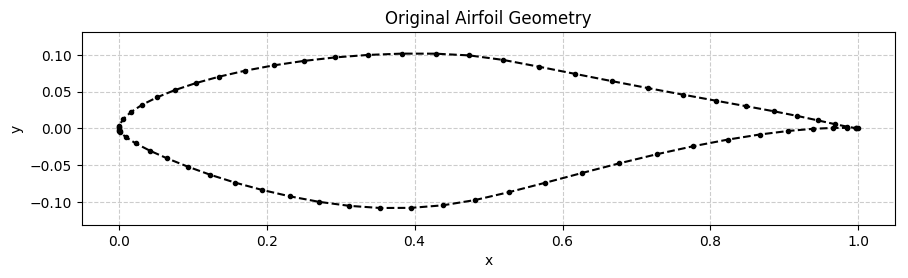

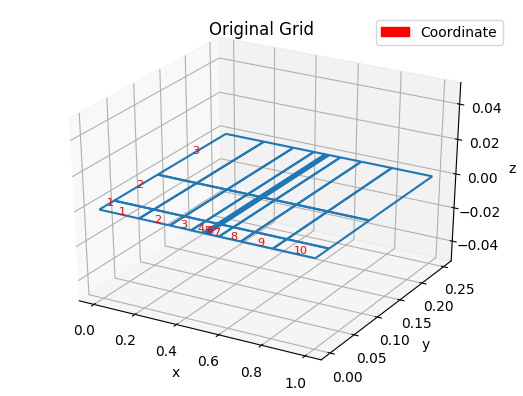

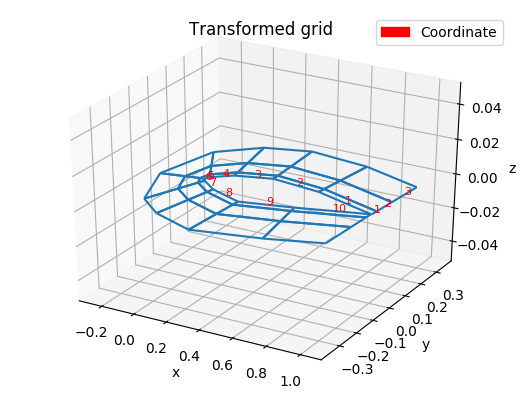

In [13]:
file_name = "temp_airfoilshapedgrid00"
paraview = true


# ----------------- READS AND PARAMETERIZES AIRFOIL ---------------------------
# Read airfoil contour
x,y = examples.readcontour(joinpath(data_path, "S809.txt"); header_len=2)
examples.plot_airfoil(x,y; style="--.k", title_str="Original Airfoil Geometry")

# Separate upper and lower surfaces to make the contour injective in x
upper, lower = examples.splitcontour(x,y)

# Parameterize both surfaces independently
fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1, s=1e-7)
fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1, s=1e-7)



# ----------------- CREATES GRID OF AIRFOIL CONTOUR ---------------------------
# Creates the grid as a two-dimensional square
#   `X[1]` is the arc-length around the airfoil contour (between 0 and 1),
#   `X[2]` is the normal distance to the airfoil

P_min = [0, 0]             # Lower boundaries arclength, dummy
P_max = [1, 0.25]          # Upper boundaries arclength, dummy
# NDIVS = [100, 5]            # 100 arclength divisions, 0 dummys
# NDIVS = [[(1.0, 100, 0.05, true)],
#          [(1.0, 10, 5.0, false)] ]           
NDIVS = [[(1.0, 10, 0.05, true)],
         [(1.0, 3, 5.0, false)] ]           
loop_dim = 0               # Loop the arclength dimension

grid = vtk.Grid(P_min, P_max, NDIVS, loop_dim)

vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, fig_name="org", title_str="Original Grid")


# Creates a space transformation function
function my_space_transform(X)
    eps = 0.001     # Epsilon for tangential direction
    up = X[1]<0.5
    
    if up
        s = 1-2*X[1]
        sgn = (-1)^(s-eps>=0)
        point = fun_upper(s)          # Evaluation point
        point2 = fun_upper(s+sgn*eps) # Point for tangential direction
    else
        s = 2*(X[1]-0.5)
        sgn = (-1)^(s-eps>=0)
        point = fun_lower(s)
        point2 = fun_lower(s+sgn*eps) 
    end
    
    tng = ((-1)^!up)*sgn*(point-point2)/norm(point-point2) # Tangential direction
    nrml = cross(tng, [0,0,1])                  # Normal direction
    
    return (point + X[2]*nrml)[1:2]
end

# Transforms the square into the airfoil-shaped grid
vtk.transform!(grid, my_space_transform)

vtk.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, title_str="Transformed grid");

if paraview
    # Outputs a vtk file
    vtk.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end

# Q&A

## How can I define a vtk line with data associated to it?

Easy peasy Kevin, this is done with the `lines2vtk()` function:

```julia
lines = # some collections of points defining lines
datas = # vector data at each point of each line

# Formats the line into vtk
points, vtk_lines, vtk_values = vtk.lines2vtk(lines; values=datas)

# Formats the original data as a data field
data = [Dict(
                "field_name" => "MyAwesomeData",
                "field_type" => "vector",
                "field_data" => vtk_values
       )]

# Outputs vtk
vtk.generateVTK(file_name, points;
                    lines=vtk_lines,
                    point_data=data)
```

In [2]:
? vtk.lines2vtk

`lines2vtk(lines; values=nothing)`

Receives an array of lines, with lines[i] the i-th line, and lines[i][j] the   j-th point in the i-th line, and formats them in vtk format. Give it point   data through `values` in the same format, and it will output the data formated   as corresponding to the vtk lines.

** Output **

  * (points, vtk_lines, vtk_values) where `points` is an array with all points in all lines, `lines` is an array of arrays containing the indices of every point in each line, and `vtk_values` is an array with the point data of each point in `points`.


The following lines defines a section of a circle's perimeter and adds vectors at every node and section point in the direction of the centroid:


<img src="img/line00.png" alt="Pic here" style="width: 300px;"/>

In [3]:
file_name = "temp_line00"
paraview = true

# ----------------- PARAMETERS ------------------------------------------------
C = zeros(3)            # Circle's centroid
R = 1                   # Radius
phi_min = -45*pi/180    # (deg) minimum angle
phi_max = 45*pi/180     # (deg) maximum angle
n = 10                  # Number of sections


# ----------------- LINE DEFINITION -------------------------------------------
# Defines every point along the line
line = []
vectors = []
for angle in linspace(phi_min, phi_max, n+1)
    
    # Point
    point = C + R*[sin(angle), cos(angle), 0]
    
    # Vector pointing towards the centroid
    vector = C - point
    
    push!(line, point)
    push!(vectors, vector)
    
end

# lines2vtk operates over multiple lines; in our case
# we have only one, but we still need to wrap it into
# an array
lines = [line]
values = [vectors]

# Formats the line into vtk
points, vtk_lines, vtk_values = vtk.lines2vtk(lines; values=values)

# Formats the vectors as a data field
data = [Dict(
                "field_name" => "Radius",
                "field_type" => "vector",
                "field_data" => vtk_values
       )]

# Outputs vtk
vtk.generateVTK(file_name, points;
                    lines=vtk_lines,
                    point_data=data)


# ----------------- VISUALIZATION ---------------------------------------------
if paraview
    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end